In [1]:
## Read in required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import pickle

In [2]:
## Read in data
train = pd.read_csv('train_sample.csv')
test = pd.read_csv('test_sample.csv')

In [3]:
## The training set is composed of 15 predictors(9 quantitative and 6 flags) and 1 response variable. 
train.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,y
0,2.639057,2.639057,2.639057,0.693147,0.000000,6.660575,1.0,0.477300,45.000000,1,1,1,1,0,0,0
1,2.197225,2.197225,2.197225,0.693147,0.000000,7.090910,1.0,0.596100,43.000000,1,0,0,0,0,0,0
2,2.079442,2.079442,2.079442,0.693147,0.000000,5.318120,1.0,0.141900,50.000000,1,0,1,1,0,0,0
3,3.044522,3.044522,3.044522,0.693147,0.000000,6.364751,1.0,0.073500,27.000000,1,0,1,1,0,0,0
4,5.129899,3.367296,4.442651,0.693147,3.367296,8.407602,4.0,0.327267,33.333333,1,1,1,1,0,1,0


In [4]:
## The test set is of the same structure. The training and test sets are non-overlapping.
test.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,y
0,2.397895,2.397895,2.397895,0.693147,0.000000,5.673323,1.000000,0.097200,40.000000,1,0,1,1,0,0,0
1,2.833213,2.833213,2.833213,0.693147,0.000000,6.175867,1.000000,0.098300,25.000000,1,0,0,1,0,0,0
2,3.178054,3.178054,3.178054,0.693147,0.000000,6.432940,1.000000,0.127600,35.000000,1,0,1,1,0,0,0
3,7.263330,6.836259,7.218910,2.890372,5.921578,10.627697,1.266667,0.261334,155.855556,1,0,0,1,0,0,0
4,4.543295,3.465736,4.543295,0.693147,0.000000,9.260082,1.000000,0.110300,13.666667,1,0,0,1,0,0,0


In [5]:
## Note that there is a severe imbalance between positive & negative lables (response variable)
train['y'].value_counts()

0    875000
1      1501
Name: y, dtype: int64

In [6]:
## Note that there is a severe imbalance between positive & negative lables (response variable)
test['y'].value_counts()

0    933000
1      1332
Name: y, dtype: int64

In [7]:
## In order to alleviate the effects of this imbalance, let's try downsampling the majority class to create a 50/50 training set
labels = train.y

# Indicies of each class' observations
i_class0 = np.where(labels == 0)[0]
i_class1 = np.where(labels == 1)[0]

# Number of observations in each class
n_class0 = len(i_class0)
n_class1 = len(i_class1)

# For every observation of class 1, randomly sample from class 0 without replacement
np.random.seed(0)
i_class0_downsampled = np.random.choice(i_class0, size=n_class1, replace=False)

# Join together class 1's target vector with the downsampled class 0's target vector
newdata = train.iloc[i_class0_downsampled].append(train.iloc[i_class1])

In [8]:
## Our resulting downsampled training set consists of 3002 entries, 50% positive and 50% negative
np.shape(newdata)

(3002, 16)

In [9]:
newdata.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,y
56481,2.772589,2.772589,2.772589,0.693147,0.000000,6.077642,1.0,0.071800,25.000000,1,0,0,0,0,0,0
772495,3.332205,3.332205,3.332205,0.693147,0.000000,6.664409,1.0,0.145900,46.000000,1,0,0,1,0,0,0
521739,4.543295,4.143135,3.465736,0.693147,0.000000,9.493186,1.5,0.384650,64.000000,1,1,0,1,0,0,0
366330,6.767343,6.380123,6.767343,2.564949,3.465736,10.076516,1.0,0.134003,11.486842,1,0,0,1,0,1,0
59868,5.231109,4.143135,5.231109,1.098612,0.000000,9.703145,1.0,0.756360,34.900000,1,1,1,1,0,0,0


In [10]:
## Check for any 'na' values
newdata.isna().any()

x1     False
x2     False
x3     False
x4     False
x5     False
x6     False
x7     False
x8     False
x9     False
x10    False
x11    False
x12    False
x13    False
x14    False
x15    False
y      False
dtype: bool

In [11]:
## Now we are ready to begin modeling. Let's divide the training data into features and response
X = newdata.drop('y', axis = 1)
y = newdata.loc[:, 'y']

In [12]:
X.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15
56481,2.772589,2.772589,2.772589,0.693147,0.000000,6.077642,1.0,0.071800,25.000000,1,0,0,0,0,0
772495,3.332205,3.332205,3.332205,0.693147,0.000000,6.664409,1.0,0.145900,46.000000,1,0,0,1,0,0
521739,4.543295,4.143135,3.465736,0.693147,0.000000,9.493186,1.5,0.384650,64.000000,1,1,0,1,0,0
366330,6.767343,6.380123,6.767343,2.564949,3.465736,10.076516,1.0,0.134003,11.486842,1,0,0,1,0,1
59868,5.231109,4.143135,5.231109,1.098612,0.000000,9.703145,1.0,0.756360,34.900000,1,1,1,1,0,0


In [13]:
## Let's further divide our training set into a training/validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=0)

In [14]:
## Let's also split our test set into features/response
X_test = test.drop('y', axis = 1)
y_test = test.loc[:, 'y']

In [15]:
## Now we are ready to train our xgboost classifier. First, lets use the validation set to observe performance
model = XGBClassifier()
model.fit(X_train , y_train)
y_val_pred = model.predict(X_val)
target_names = ['Negative', 'Positive']
print(metrics.classification_report(y_val, y_val_pred,target_names=target_names))

              precision    recall  f1-score   support

    Negative       0.89      0.90      0.90       488
    Positive       0.88      0.87      0.88       413

    accuracy                           0.89       901
   macro avg       0.89      0.89      0.89       901
weighted avg       0.89      0.89      0.89       901



In [16]:
## Here's what the results of our validation set look like
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_val_pred, y_val)
print(confusion_matrix)

[[440  54]
 [ 48 359]]


In [17]:
## Here's what the results of our test set look like
y_test_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test_pred, y_test)
print(confusion_matrix)

[[842782    183]
 [ 90218   1149]]


In [18]:
## Can we do even better by playing with the parameters?
## To do this, let's create a parameter grid that can test out combinations of multiple parameters
param_grid = {
    'max_depth': [2, 5],
    'learning_rate': [0.005, 0.01],
    'booster' : ['gbtree'],
    'n_estimators': [500, 1000],
    'subsample' : [1],
    'colsample_bytree': [0.5, 1],
    'colsample_bylevel': [0.5, 1],
    'colsample_bynode': [0.5, 1]
}
# Create a based model
xgb = XGBClassifier(random_state=0)
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = xgb, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 2)

In [19]:
## Fit the grid search to the training data
grid_result = grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   55.6s
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:  2.3min finished


{'booster': 'gbtree',
 'colsample_bylevel': 0.5,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'learning_rate': 0.01,
 'max_depth': 2,
 'n_estimators': 1000,
 'subsample': 1}

In [20]:
## Let's see what our best model parameters are
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
#for mean, stdev, param in zip(means, stds, params):
 #   print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.886245 using {'booster': 'gbtree', 'colsample_bylevel': 0.5, 'colsample_bynode': 1, 'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 1000, 'subsample': 1}


In [21]:
## Using the best model identified by the grid search, lets re-run the model on the validation set
best_grid = grid_search.best_estimator_
model = best_grid
model.fit(X_train , y_train)
y_val_pred = model.predict(X_val)
target_names = ['Negative', 'Positive']
print(metrics.classification_report(y_val, y_val_pred,target_names=target_names))

              precision    recall  f1-score   support

    Negative       0.89      0.90      0.89       488
    Positive       0.88      0.86      0.87       413

    accuracy                           0.88       901
   macro avg       0.88      0.88      0.88       901
weighted avg       0.88      0.88      0.88       901



In [22]:
## Here's what the results of our validation set look like
## Results are very similar to our "default" classifier tested prior
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_val_pred, y_val)
print(confusion_matrix)

[[438  56]
 [ 50 357]]


In [23]:
## Using the best model identified by the grid search, lets re-run the model on the test set
model.fit(X_train , y_train)
y_test_pred = model.predict(X_test)
target_names = ['Negative', 'Positive']
print(metrics.classification_report(y_test, y_test_pred,target_names=target_names))

              precision    recall  f1-score   support

    Negative       1.00      0.90      0.95    933000
    Positive       0.01      0.86      0.02      1332

    accuracy                           0.90    934332
   macro avg       0.51      0.88      0.49    934332
weighted avg       1.00      0.90      0.95    934332



In [24]:
## Here's what the results of our test set look like
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test_pred, y_test)
print(confusion_matrix)
## We can see below that this best-fit model captures a bit more True Positives at the exepnse of a bit more False Positives
## Given the imbalance and the relatively higher value of TPs(compared to the penalty of a FP), we will accept this exchange

[[841982    182]
 [ 91018   1150]]


In [25]:
## Let's take a look at feature importances. Can we remove some features to get a better model?
feature_importances = pd.Series(model.feature_importances_, X_train.columns).sort_values(ascending = False)
feature_importances

x5     0.336247
x14    0.200221
x4     0.130188
x7     0.100879
x1     0.081846
x6     0.035087
x11    0.032739
x15    0.018671
x2     0.018377
x3     0.015692
x8     0.014360
x9     0.010810
x12    0.002803
x13    0.002081
x10    0.000000
dtype: float32

Text(0.5, 1.0, 'Feature Importances')

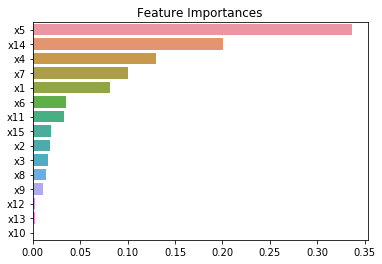

In [26]:
## Quick plot of features and their importances
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


sns.barplot(y=feature_importances.index, x=feature_importances.values)
plt.title('Feature Importances')


In [27]:
## Based on the above, let's try setting the cutoff threshold at 0.04 and remove the rest
threshold = 0.04
imp_feats = list(feature_importances[feature_importances>threshold].keys())
imp_feats

['x5', 'x14', 'x4', 'x7', 'x1']

In [28]:
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
# Only pick features that have an importance of more than the threshold 0.04
sfm = SelectFromModel(model, threshold)

# Train the selector
sfm.fit(X_train, y_train)

SelectFromModel(estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                        colsample_bylevel=0.5,
                                        colsample_bynode=1, colsample_bytree=1,
                                        gamma=0, learning_rate=0.01,
                                        max_delta_step=0, max_depth=2,
                                        min_child_weight=1, missing=None,
                                        n_estimators=1000, n_jobs=1,
                                        nthread=None,
                                        objective='binary:logistic',
                                        random_state=0, reg_alpha=0,
                                        reg_lambda=1, scale_pos_weight=1,
                                        seed=None, silent=None, subsample=1,
                                        verbosity=1),
                max_features=None, norm_order=1, prefit=False, threshold=0.04)

In [29]:
# Transform the data to create a new dataset containing only the most important features
# Note: We have to apply the transform to both the training X and test X data.
X_important_train = sfm.transform(X_train)
X_important_test = sfm.transform(X_test)

In [30]:
# Create a new random forest classifier for the most important features
model_important = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.5, gamma=0,
       learning_rate=0.01, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=500, n_jobs=1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

# Train the new classifier on the new dataset containing the most important features
model_important.fit(X_important_train, y_train)
y_pred = model_important.predict(X_important_test)
target_names = ['Negative', 'Positive']
print(metrics.classification_report(y_test, y_pred,target_names=target_names))

# There doesn't appear to be much of a difference compared to our previous model

              precision    recall  f1-score   support

    Negative       1.00      0.89      0.94    933000
    Positive       0.01      0.87      0.02      1332

    accuracy                           0.89    934332
   macro avg       0.51      0.88      0.48    934332
weighted avg       1.00      0.89      0.94    934332



In [31]:
## Let's look at the confusion matrix for the test set
y_pred = model_important.predict(X_important_test)
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_pred, y_test)
print(confusion_matrix)

## We'll just use the original best_grid model to look at raw predictions

[[834492    179]
 [ 98508   1153]]


In [32]:
## Let's see what our raw predictions look like with our original best grid model
raw_preds = model.predict_proba(X_test)[:,1]

In [33]:
## % of predictions over 0.5
len([pred for pred in raw_preds if pred>=0.5])/float(len(raw_preds))*100

9.864587748252228

array([54.65209369, 21.55775463,  6.82819383,  3.82037648,  3.27699362,
        2.43714226,  2.20531888,  2.19375982,  2.08887205,  0.93949474])

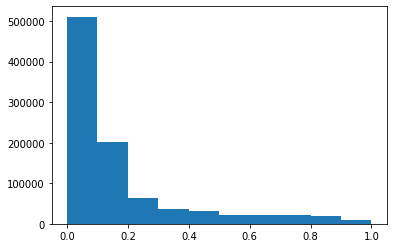

In [34]:
## Here is what the distribution of raw predictions look like: long tail, skewed right as expected
%matplotlib inline
plt.hist(raw_preds, bins = 10, range = (0,1))[0]/len(raw_preds)*100

In [35]:
## Let's do some data manipulation to see what the histogram above looks like just for positive labels
X_test['raw_preds'] = raw_preds
X_test['y'] = y_test
X_test[['raw_preds', 'y']].head()

,raw_preds,y
0,0.028840,0
1,0.032535,0
2,0.050042,0
3,0.719810,0
4,0.048723,0


array([ 1.87687688,  3.52852853,  2.62762763,  2.62762763,  3.003003  ,
        2.77777778,  3.67867868,  6.60660661, 11.93693694, 61.33633634])

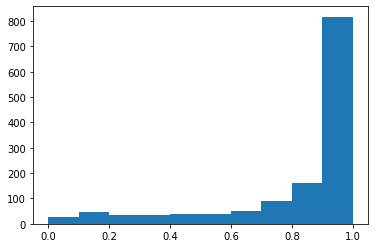

In [36]:
## Below is a histogram of positive labels in the test set and their corresponding scores
positives = X_test[X_test['y']>0]
plt.hist(positives.raw_preds, bins = 10, range = (0,1))[0]/len(positives)*100
## 61% of the positives received scores of 0.9 or higher (817/1332, 61.3%)
## 73% of the positives received scores of 0.8 or higher (972/1332, 73.3%)
## 86% of the positives received scores of 0.5 or higher (1145/1332, 86.0%)

In [37]:
## Let's save our xgboost model using the pickle module
import pickle
pickle.dump(model, open("xgb.pickle.dat", "wb"))

In [38]:
## We can use load the model with the following for future use
loaded_model = pickle.load(open("xgb.pickle.dat", "rb"))
model.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 0.5,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.01,
 'max_delta_step': 0,
 'max_depth': 2,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 1000,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 1,
 'verbosity': 1}